# Content-Based Movie Recommender System

This notebook shows the implementation of a **content-based movie recommender system**, which suggests movies based on their content features, such as plot descriptions. The system computes similarities between movies using different methods, such as **TF-IDF** and **CountVectorizer**, to create a movie profile and recommend similar movies to a user based on their preferences.

The steps involved in building the recommender system include:

1. **Loading Data**:
   - We start by loading two datasets: `tmdb_5000_movies.csv` (which contains information about the movies) and `tmdb_5000_credits.csv` (which provides information about the cast and crew of the movies).
   
2. **Preprocessing**:
   - Missing values in movie descriptions (`overview`) are handled by filling them with empty strings.
   - We calculate a **weighted rating** for each movie by combining its average rating and the number of votes, giving higher weight to movies with more votes.
   
3. **Feature Representation**:
   - **TF-IDF Vectorization**:
     - We transform the movie overviews into numerical representations using **TF-IDF** (Term Frequency-Inverse Document Frequency). This method helps capture the importance of words in the movie descriptions while considering their relevance across the entire dataset.
   - **Count Vectorization**:
     - As an alternative to TF-IDF, we use **CountVectorizer** to represent the overviews as a "bag-of-words" model, which counts the frequency of each word in the descriptions.

4. **Similarity Computation**:
   - **Cosine Similarity**:
     - We compute the similarity between movies using **cosine similarity**, which measures the angular distance between movie feature vectors.
   - **Pearson Correlation**:
     - Additionally, **Pearson correlation** is used to measure the linear relationship between movies based on their feature vectors.

5. **Recommendation**:
   - The final recommendation is based on a movie title (first case) or on the centroid of the embeddings of the movies in the user's profile (real scenario). Movies with the highest similarity to this centroid are recommended, while those already included in the user profile are excluded from the recommendations.


First, we install the dependencies

In [1]:
!pip install seaborn
!pip install wordcloud
!pip install pandas

Then, we download the dataset

In [2]:
!wget https://github.com/giuspillo/MRI-24-25_CBRS/blob/main/cbrs_simple/data/movies.csv
!wget https://github.com/giuspillo/MRI-24-25_CBRS/blob/main/cbrs_simple/data/credits.csv

--2024-12-17 09:39:49--  https://github.com/giuspillo/MRI-24-25_CBRS/blob/main/cbrs_simple/data/movies.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘movies.csv’

movies.csv              [ <=>                ] 221.33K  --.-KB/s    in 0.01s   

2024-12-17 09:39:49 (14.9 MB/s) - ‘movies.csv’ saved [226637]

--2024-12-17 09:39:49--  https://github.com/giuspillo/MRI-24-25_CBRS/blob/main/cbrs_simple/data/credits.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘credits.csv’

credits.csv             [ <=>                ] 221.35K  --.-KB/s    in 0.007s  

2024-12-17 09:39:50 (29.4 MB/s) - ‘credits.csv’ saved [226663]



In [3]:
!curl -O https://raw.githubusercontent.com/giuspillo/MRI-24-25_CBRS/refs/heads/main/cbrs_simple/data/movies.csv
!curl -O https://raw.githubusercontent.com/giuspillo/MRI-24-25_CBRS/refs/heads/main/cbrs_simple/data/credits.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5574k  100 5574k    0     0  11.3M      0 --:--:-- --:--:-- --:--:-- 11.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.1M  100 38.1M    0     0  34.2M      0  0:00:01  0:00:01 --:--:-- 34.2M


Then, we import the libraries we will exploit

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap

## Read and Prepare Data

### Reading the Input Data

This section loads the required datasets into Pandas DataFrames:

- **`tmdb_5000_movies.csv`**: Contains metadata about movies, such as genres, descriptions, keywords, and other features that may be used for content-based recommendations.
- **`tmdb_5000_credits.csv`**: Includes cast and crew information for each movie, which can be leveraged as additional content features.

The data is read using `pd.read_csv` and stored in the variables `movie_data_all` and `credit_data_all` for further processing and analysis.


In [5]:
# Read the input data
input_data_file_movie = "movies.csv"
movie_data_all = pd.read_csv(input_data_file_movie, encoding='utf-8')

### Previewing the Movie Dataset

This cell uses the `head(2)` method to display the first two rows of the `movie_data_all` DataFrame. This provides a quick preview of the structure and content of the dataset, including key columns such as:

- **Movie metadata** (e.g., title, genres, overview, etc.)
- Any other available features that can be used for building a content-based recommender system.

This preview helps verify that the dataset has been loaded correctly and gives an initial look at the data format.


In [6]:
movie_data_all.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [7]:
print("Shape of movies dataset =", movie_data_all.shape)

Shape of movies dataset = (4803, 20)


## Let's build the model

#### Calculating Weighted Ratings for Movies

This cell implements a mechanism to compute a **weighted rating** for movies, which adjusts the rating based on the number of votes received. This is useful for ranking movies more fairly, especially in a content-based recommender system, by giving importance to movies with higher vote counts.


1. **Minimum Number of Votes ($m$)**:
   - The 90th percentile of the `vote_count` column is calculated to determine the threshold (`m`) for a movie to be considered among the top 10%.
   
2. **Mean Rating ($C$)**:
   - The overall mean of the `vote_average` column is calculated to serve as a baseline rating.

3. **Weighted Rating Formula**:
   - A custom function, `weighted_rating`, is defined to compute the weighted rating for a movie based on the formula:
     $ \text{Weighted Rating} = \left(\frac{v}{v+m} \cdot R\right) + \left(\frac{m}{v+m} \cdot C\right) $
     Where:
     - $v$ = Number of votes for the movie.
     - $R$ = Average rating of the movie.
     - $m$ = Minimum number of votes required.
     - $C$ = Mean rating across all movies.

4. **Adding Weighted Ratings**:
   - The `apply` method is used to compute the weighted rating for each movie in the dataset, and the results are stored in a new column called `weighted_rating`.

Finally, the `head(2)` method is used to display the first two rows of the updated DataFrame, showcasing the new `weighted_rating` column.


In [8]:
# Calculate the minimum number of votes required to be in the chart (top 10%)
m = movie_data_all['vote_count'].quantile(0.90)
# Calculate mean of vote across all movies
C = movie_data_all['vote_average'].mean()

# Compute the weighted rating of each movie
def weighted_rating(movies):
    v = movies['vote_count']
    R = movies['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)


# Add a column weighted_rating and store the computed weighted rating for all movies
movie_data_all['weighted_rating'] = movie_data_all.apply(weighted_rating, axis=1)
movie_data_all.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,weighted_rating
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.665696


#### Conten-based Recommender system based on Plot (Overview) of movies

Let's see how the plots are

In [9]:
# Quick look at the plots
movie_data_all[['original_title', 'overview']].head(5)

,original_title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."


In [10]:
# let's print the overview of one of the movies
print(movie_data_all[movie_data_all['original_title'] == 'The Dark Knight Rises']['overview'].values[0])

Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy.


### Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document (overviews)

### Constructing the TF-IDF Matrix

This cell uses the **TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer** to transform the textual data (movie overviews) into a numerical form: in this way, the textual description can be treated by the Recommender System.

**Understanding TF-IDF**

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a statistical technique used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It transforms text data into numerical representations, making it suitable for machine learning models and similarity computations.

#### Components:
1. **Term Frequency (TF)**:
   - Measures how frequently a term occurs in a document.
   - $TF = \frac{\text{Number of times term } t \text{ appears in a document}}{\text{Total number of terms in the document}}$
   

2. **Inverse Document Frequency (IDF)**:
   - Measures how unique a term is across all documents.
   - $IDF = \log{\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}}$

3. **TF-IDF Value**:
   - Combines both components to assign a weight to each term in a document.
   - Terms that are frequent in a document but rare in the corpus get higher scores.
   - $\text{TF-IDF} = TF \times IDF$

#### Purpose in Recommender Systems:
- TF-IDF captures the semantic meaning of textual data by representing each document (e.g., movie overview) as a vector of weighted term frequencies.
- These vectors can be used to calculate similarity between items, enabling **content-based recommendations**.

#### Application:
In the context of a content-based recommender system, the TF-IDF matrix is constructed from movie overviews, where:
- Rows represent individual movies.
- Columns represent unique terms from the combined overviews.
- The resulting matrix forms the basis for identifying similar movies by comparing their vector representations.


1. **Importing the TF-IDF Vectorizer**:
   - The `TfidfVectorizer` from `sklearn.feature_extraction.text` is used to compute the importance of words in the movie overviews while reducing the impact of commonly used words (e.g., "the", "and").

2. **Handling Missing Data**:
   - Missing values in the `overview` column are replaced with empty strings using `fillna('')` to ensure compatibility with the vectorizer.

3. **Fitting and Transforming Data**:
   - The `TfidfVectorizer` is applied to the `overview` column of the dataset, creating a **TF-IDF matrix** where:
     - Rows represent movies.
     - Columns represent unique terms from the overviews.
     - Values indicate the importance of a term in a particular movie’s overview.

4. **TF-IDF Matrix Shape**:
   - The dimensions of the resulting TF-IDF matrix are printed, showing the number of movies (rows) and the size of the vocabulary (columns).

This matrix serves as the foundation for calculating content-based similarity between movies based on their overviews.


In [11]:
# Define a TF-IDF Vectorizer Object
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Remove NaN from Overview with empty strings
movie_data_all['overview'] = movie_data_all['overview'].fillna('')

# Construct TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie_data_all['overview'])

print("Shape of TF-IDF matrix =", tfidf_matrix.shape)

tfidf_matrix.shape

Shape of TF-IDF matrix = (4803, 20978)


(4803, 20978)

### Compute count vectors for each document (overviews) to find the most frequently occuring words

#### Constructing the CountVectorizer Matrix

This cell uses the **CountVectorizer** to transform the text data from movie overviews into a bag-of-words representation. Unlike TF-IDF, CountVectorizer focuses solely on term frequencies without scaling them by their uniqueness across the dataset.

1. **Importing CountVectorizer**:
   - The `CountVectorizer` from `sklearn.feature_extraction.text` is initialized with English stop words to exclude common terms that don't carry significant meaning (e.g., "and", "the").

2. **Handling Missing Data**:
   - Missing values in the `overview` column are replaced with empty strings using `fillna('')`.

3. **Fitting and Transforming Data**:
   - The `fit_transform` method is applied to the `overview` column, creating a **CountVectorizer matrix** where:
     - Rows represent movies.
     - Columns represent unique terms from the overviews.
     - Values indicate the count of each term in a movie's overview.

4. **Inspecting Matrix Shape**:
   - The dimensions of the resulting matrix are printed, showing the number of movies (rows) and the vocabulary size (columns).

5. **Analyzing Frequent Terms**:
   - The top 20 most frequently occurring words in the movie overviews are identified and displayed using the following:
     - `get_feature_names()` retrieves the vocabulary.
     - `sum(axis=0)` calculates the total count of each term across all movies.
     - The terms and their counts are sorted in descending order.



In [12]:
# Define a CountVectorizer Object
from sklearn.feature_extraction.text import CountVectorizer
cntVec = CountVectorizer(stop_words='english')

# Remove NaN from Overview with empty strings
movie_data_all['overview'] = movie_data_all['overview'].fillna('')

# Construct CountVectorizer matrix by fitting and transforming the data
cntVec_matrix = cntVec.fit_transform(movie_data_all['overview'])

print("Shape of CountVectorizer matrix =", cntVec_matrix.shape)

# Topmost frequently occuring words
words = cntVec.get_feature_names_out()
counts = cntVec_matrix.sum(axis=0).reshape(-1,1).tolist()
print("Most frequently occuring words in plot overview:")
word_count = dict(sorted(zip(words, counts), key=lambda x : x[1], reverse=True)[:20])
print(word_count)

Shape of CountVectorizer matrix = (4803, 20978)
Most frequently occuring words in plot overview:
{'life': [873], 'new': [719], 'young': [635], 'world': [632], 'man': [586], 'family': [541], 'story': [451], 'love': [431], 'old': [372], 'father': [360], 'years': [351], 'time': [349], 'finds': [331], 'friends': [320], 'help': [317], 'film': [315], 'town': [311], 'year': [308], 'school': [306], 'lives': [299]}


### Generate few Word Clouds, just for fun :-)

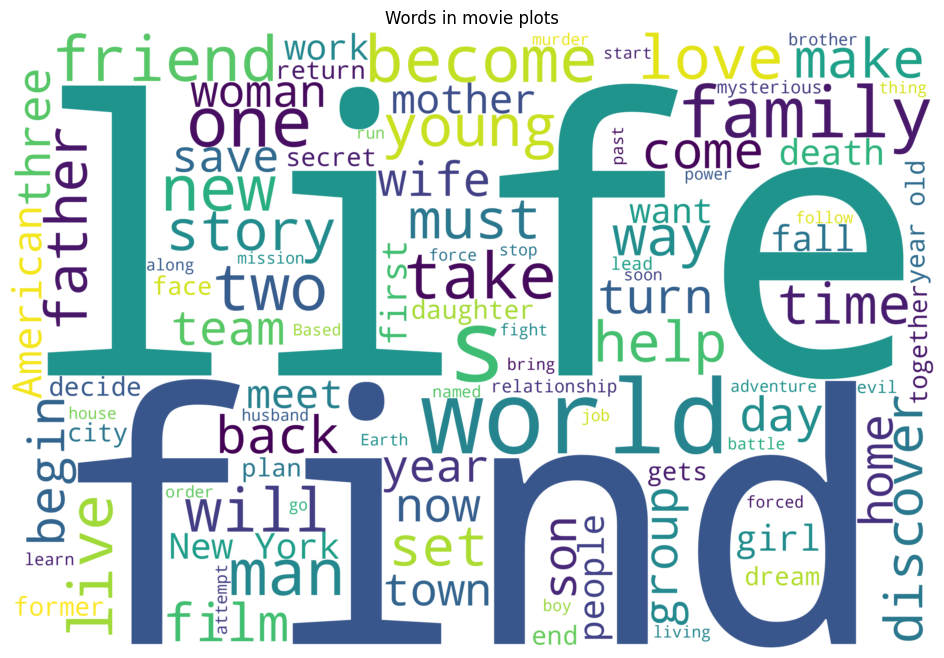

In [13]:
# Generate a word cloud image of plot overview
from wordcloud import WordCloud

overview_all = [overview for overview in movie_data_all.overview]

wordcloud = WordCloud(max_words=100, relative_scaling=0.5, background_color='white',
                      height=2000, width=3000)
wordcloud = wordcloud.generate(str(overview_all))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words in movie plots')
plt.show()

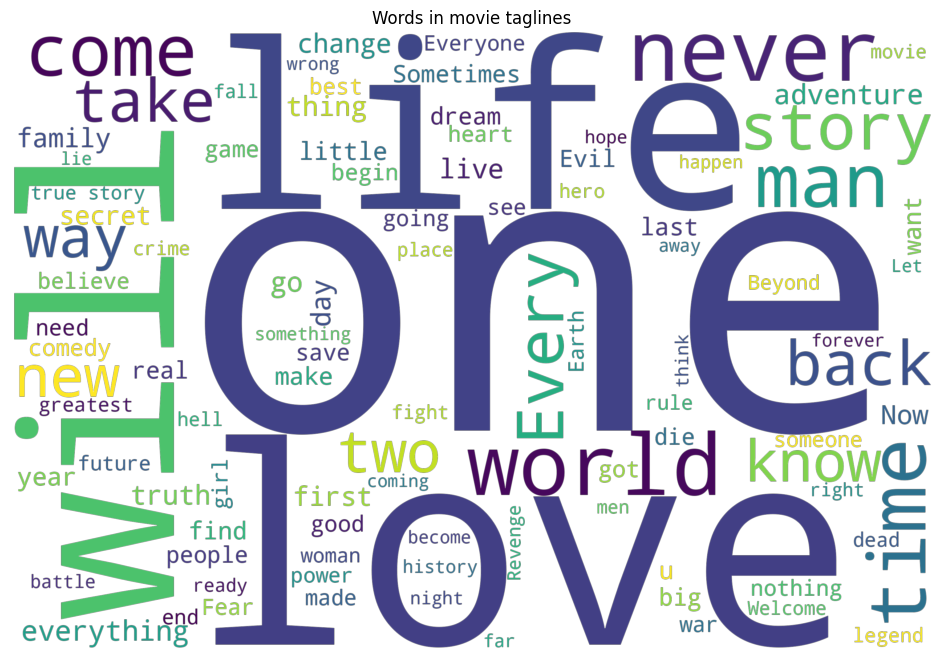

In [14]:
# Generate a word cloud image of tagline
from wordcloud import WordCloud

movie_data_all['tagline'] = movie_data_all['tagline'].fillna('')
tagline_all = [tagline for tagline in movie_data_all.tagline]

wordcloud = WordCloud(max_words=100, relative_scaling=0.5, background_color=None,
                      mode='RGBA', height=2000, width=3000)
wordcloud = wordcloud.generate(str(tagline_all))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words in movie taglines')
plt.show()

Construct reverse mapping of movie title to movie index.

We will later use this map in the `get_recommender` function to fetch movie index from movie title.

In [15]:
movie_indices = pd.Series(movie_data_all.index, index=movie_data_all['title']).drop_duplicates()
movie_indices.head(5)

,0
title,
Avatar,0
Pirates of the Caribbean: At World's End,1
Spectre,2
The Dark Knight Rises,3
John Carter,4


### Computing Cosine Similarity

This cell defines a function to compute **cosine similarity** between movies based on their textual representations (e.g., TF-IDF or CountVectorizer matrices).

Cosine similarity is a measure of the angular distance between two vectors, commonly used in text analysis to quantify similarity.

1. **Importing `linear_kernel`**:
   - The `linear_kernel` function from `sklearn.metrics.pairwise` is used to compute the cosine similarity efficiently. Unlike other similarity functions, `linear_kernel` avoids explicit normalization, making it suitable for large datasets.

2. **Defining the Function**:
   - The `computeCosineSimilarity` function takes a word matrix as input, where:
     - Rows represent items (e.g., movies).
     - Columns represent features (e.g., term weights).
   - The function computes pairwise cosine similarity as follows, given $A$ and $B$ two vectors (e.g., the vectors associated to two movies):

   $$
   \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
   $$

3. **Output**:
   - Returns a cosine similarity matrix, where:
     - Each entry $(i, j)$ represents the similarity between movie $i$ and movie $j$.



In [16]:
# Compute cosine similarity, similar to correlation
from sklearn.metrics.pairwise import linear_kernel

def computeCosineSimilarity(word_matrix):
    cosine_similarity = linear_kernel(word_matrix, word_matrix)
    return cosine_similarity

### Utility function to compute Pearson Correlation

### Computing Pearson Correlation

This cell defines a function to compute the **Pearson correlation coefficient** between items (e.g., movies) based on their textual representations.

1. **Defining the Function**:
   - The `computePearsonCorrelation` function takes a word matrix as input, where:
     - Rows represent items (e.g., movies).
     - Columns represent features (e.g., term weights).
   - The function uses `np.corrcoef` to compute the Pearson correlation, a statistical measure of the linear relationship between two variables. It is defined as:
   
  $$r = \frac{\text{Cov}(X,Y) } { \sigma_X \sigma_Y } $$
     
     Where:
     - $\text{Cov}(X, Y)$ is the covariance of $X$ and $Y$.
     - $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$.

2. **Output**:
   - Returns a Pearson correlation matrix, where:
     - Each entry $(i,j)$ represents the correlation coefficient between movie $i$ and movie $j$.



In [17]:
# Compute Pearson correlation
def computePearsonCorrelation(word_matrix):
    return np.corrcoef(word_matrix)

### Getting Movie Recommendations

This cell defines the function `get_movie_recommendations`, which takes a movie title and a similarity score matrix to return a list of the top 10 most similar movies based on their content.


1. **Fetching the Movie Index**:
   - The `movie_title` input is used to find the index of the movie in the `movie_indices` dictionary. This index will be used to locate the similarity scores for that movie.

2. **Extracting Similarity Scores**:
   - The function retrieves the similarity scores for the given movie by accessing the corresponding row in the `similarity_scores` matrix.
   - The similarity scores are then converted into a list of tuples, where each tuple contains the index of another movie and its similarity score.

3. **Sorting the Scores**:
   - The similarity scores are sorted in descending order, ensuring that the most similar movies appear first.

4. **Selecting the Top 10 Similar Movies**:
   - The top 10 most similar movies are selected, excluding the movie itself (i.e., the 0th index is skipped).

5. **Fetching Movie Titles and Ratings**:
   - The indices of the top 10 similar movies are used to extract the movie titles and their weighted ratings from the `movie_data_all` DataFrame.
   - The results are sorted by `weighted_rating` to prioritize highly rated movies.

6. **Returning the Results**:
   - The function returns a DataFrame containing the titles and weighted ratings of the top 10 most similar movies.



In [22]:
def get_movie_recommendations(movie_title, similarity_scores):
    # Fetch index of movie based on given title
    movie_idx = movie_indices[movie_title]

    # Fetch similarity score of all movies with the given movie
    # Fetch it as a tuple of (index, score)
    similarity_scores = list(enumerate(similarity_scores[movie_idx]))

    # Sort the above score
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Pick index and score of 10 most similar movies
    # Skip the 0th index since it is same movie (itself)
    similarity_scores = similarity_scores[1:11]

    # Find the indices of these similar movies
    movie_similar_indices = [i[0] for i in similarity_scores]

    # Find title of these top movies and return
    movie_similar_titles = movie_data_all[['title', 'weighted_rating']] \
                            .iloc[movie_similar_indices] \
                            .sort_values('weighted_rating', ascending=False)


    return movie_similar_titles

### Let's try these recommender systems

In [23]:
# Find recommendations based on Cosine Similarity
cosine_similarity = computeCosineSimilarity(tfidf_matrix)
get_movie_recommendations('Spectre', cosine_similarity)

,title,weighted_rating
29,Skyfall,6.742719
4339,Dr. No,6.365479
1717,Safe Haven,6.341981
4071,From Russia with Love,6.328451
3162,Thunderball,6.187655
3336,Diamonds Are Forever,6.140231
1743,Octopussy,6.116195
11,Quantum of Solace,6.097004
1343,Never Say Never Again,6.046797
1880,Dance Flick,6.040404


In [24]:
# Find recommendations based on Pearson correlation
corrcoef_similarity = computePearsonCorrelation(tfidf_matrix.toarray())
get_movie_recommendations('Spectre', corrcoef_similarity)

,title,weighted_rating
2501,Hachi: A Dog's Tale,6.868636
29,Skyfall,6.742719
1717,Safe Haven,6.341981
4071,From Russia with Love,6.328451
1743,Octopussy,6.116195
1200,The Living Daylights,6.112995
11,Quantum of Solace,6.097004
1131,Licence to Kill,6.048478
1343,Never Say Never Again,6.046797
1880,Dance Flick,6.040404


In [ ]:
tfidf_matrix.shape

(4803, 20978)

In [ ]:
cosine_similarity.shape

(4803, 4803)

## But...

In a real scenario, we want to recommend movies to users who already watched more than one movie.

So, we need to adapt the recommendation function at handling different movie titles.


### Generating Movie Recommendations Based on User Profile

In this cell, we provide the function with the original **TF-IDF embeddings** computed earlier. The key change here is that, instead of relying on precomputed similarity structures, we need to compute the similarity on-the-fly. This is because we cannot know in advance which movies will be in the user profile, making it impossible to use any prebuilt data structures like similarity matrices.

1. **User Profile Creation**:
   - The user profile is formed by computing the **centroid (average)** of the embeddings of the movies in the user's profile (in this case, `'The Avengers'` and `'Star Wars'`).
   - This centroid represents the user's preferences based on the selected movies.

2. **Cosine Similarity Computation**:
   - Since we don't have precomputed similarity scores, we compute the cosine similarity between the user profile and all movies in the catalog based on their TF-IDF embeddings.
   - This involves comparing the average vector (centroid) of the selected movies with every movie's vector in the catalog.

3. **Efficiency Considerations**:
   - This approach **reduces efficiency** because we're computing similarity dynamically, rather than leveraging a precomputed matrix.
   - Although this approach isn't as efficient as using a prebuilt structure, we must handle the **scalability problem**, which arises when dealing with an unknown set of movies in the user profile.

4. **Recommendation Generation**:
   - After calculating the similarity scores, the function returns the top **k most similar movies**, excluding those already in the user's profile.



In [25]:
import numpy as np

def get_movie_recommendations_given_profile(movie_titles, similarity_scores, k=10):

    # Fetch the indices of the given movie titles from the movie_indices dictionary
    movie_indices_list = [movie_indices[title] for title in movie_titles if title in movie_indices]

    # Compute the centroid of the embeddings for the given movie titles
    # similarity_scores is assumed to be a similarity matrix or a vector of movie embeddings
    # Here, we are using similarity_scores to represent the embeddings for simplicity
    movie_embeddings = similarity_scores[movie_indices_list]  # Get the embeddings of the selected movies
    user_profile_embedding = np.asarray(np.mean(movie_embeddings, axis=0))  # Compute the centroid (average) and convert to numpy array

    # Compute the cosine similarity between the user profile embedding and all other movie embeddings
    cosine_similarities = linear_kernel(user_profile_embedding.reshape(1, -1), similarity_scores).flatten()

    # Create a list of (movie index, similarity score) tuples
    similarity_scores_with_index = list(enumerate(cosine_similarities))

    # Sort the scores in descending order
    similarity_scores_with_index = sorted(similarity_scores_with_index, key=lambda x: x[1], reverse=True)

    # Filter out the movies that are already in the profile (we exclude movie_indices_list)
    recommended_movies = []
    for idx, score in similarity_scores_with_index:
        if idx not in movie_indices_list:  # Exclude movies already in the user profile
            recommended_movies.append((idx, score))
            if len(recommended_movies) == k:  # Stop once we have 'k' recommendations
                break

    # Extract the movie titles and weighted ratings for the top 'k' recommendations
    movie_similar_indices = [movie[0] for movie in recommended_movies]
    movie_similar_titles = movie_data_all[['title', 'weighted_rating']] \
                            .iloc[movie_similar_indices] \
                            .sort_values('weighted_rating', ascending=False)

    return movie_similar_titles


In [26]:
# This time we need to provide the function the original embeddings (TF-IDF embedding) we computed before
# since we cannot know a-priori which movies will be in the user profile,
# so we won't be able to exploit an already-computed data structure

# Even if this decreases the overall efficency, we do not have so many choices: welcome to the scalability problem :)
get_movie_recommendations_given_profile(['The Avengers', 'Star Wars'], tfidf_matrix)

,title,weighted_rating
1990,The Empire Strikes Back,7.697884
1490,Return of the Jedi,7.388958
85,Captain America: The Winter Soldier,7.235379
7,Avengers: Age of Ultron,7.041968
711,RED,6.399072
2136,Team America: World Police,6.226324
1290,Baahubali: The Beginning,6.188481
833,Shanghai Noon,6.122969
3144,Plastic,6.092521
2002,Haywire,5.986109


## Let's now exploit other features

First, we load the other features (stored in the credits file), and then we merge with the original movie file.

In [33]:
# Load credits file
input_data_file_credit = "credits.csv"
credit_data_all = pd.read_csv(input_data_file_credit)

In [34]:
# Show the first rows
credit_data_all.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [35]:
# Merge movies and credit dataset
movie_credit_merged = movie_data_all.merge(credit_data_all,
                                           left_on=['id', 'title'],
                                           right_on=['movie_id', 'title'],
                                           how='inner')
movie_credit_merged.shape

(4803, 24)

In [36]:
movie_credit_merged.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.665696,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,6.239396,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,7.346721,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,6.096368,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Few utility functions to extract/convert and store modified values in new columns
1. Convert stringified lists into dictionary
2. Fetch name of director from crew data
3. Fetch names of first 5 actors from cast data
4. Fetch names of all genres from genres data
5. Fetch first 10 keywords from keywords data

First, we build a dictionary in the format "feature -> value", and edit the filed in the pandas.

In [37]:
# Convert stringified lists data into list of dictionaries
from ast import literal_eval

features = ['cast', 'crew', 'genres', 'keywords']

for feature in features:
    movie_credit_merged[feature] = movie_credit_merged[feature].apply(literal_eval)

movie_credit_merged[features].head(1)

,cast,crew,genres,keywords
0,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':..."


In [38]:
movie_credit_merged.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.665696,285,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,6.239396,206647,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,7.346721,49026,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,6.096368,49529,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


Then, we exploit this new field to add a new column, director, that encodes the director of the movie.

In [39]:
# Find the name of the director from crew data
def get_director(crew):
    director = ''
    for data in crew:
        if data.get('job') == 'Director':
            director = data.get('name')
            break

    return director


# Create a new column Director and store name of director
movie_credit_merged['director'] = movie_credit_merged['crew'].apply(get_director)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron


Similarly, we can add a new column, and encode the first 5 actors and actress for each movie

In [43]:
# Find name of first 5 actors from cast credit roll
def get_actors(cast):
    actor_names = []
    if isinstance(cast, list):
        actor_names = [name['name'] for name in cast]
        # Check if more than 3 elements exist. If yes,
        # return only first 5. If no, return entire list.
        if len(actor_names) > 5:
            actor_names = actor_names[:5]

    return actor_names

# Create a new column Actors and store names of Actors
movie_credit_merged['actors'] = movie_credit_merged['cast'].apply(get_actors)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,genre_names,keyword_names,actors
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave..."


Again, with the genres of the movies

In [44]:
# Find name of genres from genres data
def get_genres(genres):
    genre_names = []
    if isinstance(genres, list):
        genre_names = [name['name'] for name in genres]

    return genre_names

# Create a new column genre_names and store names of genres
movie_credit_merged['genre_names'] = movie_credit_merged['genres'].apply(get_genres)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,genre_names,keyword_names,actors
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave..."


Finally, we adopt the same methodology to add some relevant keywords for each movie, as a new column.

In [45]:
# Find name of first 10 keywords from keywords data
def get_keywords(keywords):
    keyword_names = []
    if isinstance(keywords, list):
        keyword_names = [name['name'] for name in keywords]
        # Check if more than 10 elements exist. If yes,
        # return only first 10. If no, return entire list.
        if len(keyword_names) > 5:
            keyword_names = keyword_names[:10]

    return keyword_names

# Create a new column keyword_names and store names of keywords
movie_credit_merged['keyword_names'] = movie_credit_merged['keywords'].apply(get_keywords)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,genre_names,keyword_names,actors
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave..."


Once we have addedd these new columns, we select them as features we want to operate on.

In [46]:
# Dataset with key features for content-based recommender system
reco_features = ['title', 'director', 'actors', 'keyword_names', 'genre_names']
movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]"
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[spy, based on novel, secret agent, sequel, mi...","[Action, Adventure, Crime]"
3,The Dark Knight Rises,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman, A...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]"
4,John Carter,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]"


Now, to make all these strings more easy to compute, we clean data as follows:
- we convert all the names to lowercase  
- we remove spaces between names and surname.

In [47]:
# Clean up data
def cleanUpData(data):
    if isinstance(data, list):
        return [str.lower(val.replace(" ", "")) for val in data]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(data, str):
            return str.lower(data.replace(" ", ""))
        else:
            return ''

# Apply data cleanup to reco features
modified_features = ['director', 'actors', 'keyword_names', 'genre_names']

for feature in modified_features:
    movie_credit_merged[feature] = movie_credit_merged[feature].apply(cleanUpData)

movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver, ...","[cultureclash, future, spacewar, spacecolony, ...","[action, adventure, fantasy, sciencefiction]"
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley, ste...","[ocean, drugabuse, exoticisland, eastindiatrad...","[adventure, fantasy, action]"
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux, ralp...","[spy, basedonnovel, secretagent, sequel, mi6, ...","[action, adventure, crime]"
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman, anne...","[dccomics, crimefighter, terrorist, secretiden...","[action, crime, drama, thriller]"
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton, wi...","[basedonnovel, mars, medallion, spacetravel, p...","[action, adventure, sciencefiction]"


Now, we mix all these data into a soup
**yummy**

In [48]:
# Mix all the modified_features into soup
def createSoup(data):
    return data['director'] + ' ' + ' '.join(data['actors']) \
            + ' ' + ' '.join(data['keyword_names']) + ' ' + ' '.join(data['genre_names'])

createSoup(movie_credit_merged.iloc[0,:])

# Create a new feature Soup with mixed data
movie_credit_merged['soup'] = movie_credit_merged.apply(createSoup, axis=1)

reco_features = ['title', 'director', 'actors', 'keyword_names', 'genre_names', 'soup']
movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names,soup
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver, ...","[cultureclash, future, spacewar, spacecolony, ...","[action, adventure, fantasy, sciencefiction]",jamescameron samworthington zoesaldana sigourn...
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley, ste...","[ocean, drugabuse, exoticisland, eastindiatrad...","[adventure, fantasy, action]",goreverbinski johnnydepp orlandobloom keirakni...
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux, ralp...","[spy, basedonnovel, secretagent, sequel, mi6, ...","[action, adventure, crime]",sammendes danielcraig christophwaltz léaseydou...
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman, anne...","[dccomics, crimefighter, terrorist, secretiden...","[action, crime, drama, thriller]",christophernolan christianbale michaelcaine ga...
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton, wi...","[basedonnovel, mars, medallion, spacetravel, p...","[action, adventure, sciencefiction]",andrewstanton taylorkitsch lynncollins samanth...


### CountVectorizerSoup
As before, now we build a CountVectorizer object based on this soup

In [49]:
# Define a CountVectorizer Object
from sklearn.feature_extraction.text import CountVectorizer
cntVec = CountVectorizer(stop_words='english')

# Remove NaN from soup with empty strings
movie_credit_merged['soup'] = movie_credit_merged['soup'].fillna('')

# Construct CountVectorizer matrix by fitting and transforming the data
cntVec_matrix = cntVec.fit_transform(movie_credit_merged['soup'])

print("Shape of CountVectorizer matrix =", cntVec_matrix.shape)

# Topmost frequently occuring words
words = cntVec.get_feature_names_out()
counts = cntVec_matrix.sum(axis=0).reshape(-1,1).tolist()
print("Most frequently occuring words in plot overview:")
word_count = dict(sorted(zip(words, counts), key=lambda x : x[1], reverse=True)[:20])
print(word_count)

Shape of CountVectorizer matrix = (4803, 19502)
Most frequently occuring words in plot overview:
{'drama': [2307], 'comedy': [1746], 'thriller': [1276], 'action': [1157], 'romance': [915], 'adventure': [806], 'crime': [705], 'family': [569], 'sciencefiction': [540], 'horror': [530], 'fantasy': [442], 'mystery': [353], 'independentfilm': [286], 'womandirector': [264], 'animation': [257], 'duringcreditsstinger': [231], 'music': [225], 'history': [204], 'basedonnovel': [197], 'war': [181]}


Now, let's use this new data structure to get some recommendations, the same way we did before

In [50]:
# Find recommendations based on Cosine Similarity
cosine_similarity = computeCosineSimilarity(cntVec_matrix)
get_movie_recommendations('Spectre', cosine_similarity)

,title,weighted_rating
277,Casino Royale,6.909992
29,Skyfall,6.742719
134,Mission: Impossible - Rogue Nation,6.734009
370,Now You See Me 2,6.479747
11,Quantum of Solace,6.097004
1077,Johnny English,6.062983
1100,Johnny English Reborn,6.059552
1234,The Art of War,6.058502
1343,Never Say Never Again,6.046797
1084,The Glimmer Man,6.020351


In [51]:
# Find recommendations based on Pearson correlation
corrcoef_similarity = computePearsonCorrelation(cntVec_matrix.toarray())
get_movie_recommendations('Spectre', corrcoef_similarity)

,title,weighted_rating
29,Skyfall,6.742719
134,Mission: Impossible - Rogue Nation,6.734009
11,Quantum of Solace,6.097004
3318,Witless Protection,6.062995
1100,Johnny English Reborn,6.059552
1234,The Art of War,6.058502
1343,Never Say Never Again,6.046797
1084,The Glimmer Man,6.020351
2050,The Transporter Refueled,5.884145
2046,RoboCop 3,5.822921


As before, we can also get a recommendation list based on a profile

In [52]:
get_movie_recommendations_given_profile(['The Avengers', 'Star Wars'], cntVec_matrix)

,title,weighted_rating
1990,The Empire Strikes Back,7.697884
85,Captain America: The Winter Soldier,7.235379
68,Iron Man,7.173486
7,Avengers: Age of Ultron,7.041968
26,Captain America: Civil War,6.895935
182,Ant-Man,6.783770
31,Iron Man 3,6.677751
126,Thor: The Dark World,6.602640
169,Captain America: The First Avenger,6.494930
79,Iron Man 2,6.492535
